![title](../images/header.png)

# Vc - Supervised Subsampling to extract points for visual interpretation 
-------
Using the outputs from Script 5b, the change probability is divided into 3 strata, which are proportionally sampled for validation
You can use this script to export samples as csv to create your own CEO projects
This may be run with an m4 instance
###### For more information contact aurelie.shapiro@fao.org or remi.dannunzio@fao.org

In [1]:
from pathlib import Path

import numpy as np
import pandas as pd
import geopandas as gpd
import uuid
from matplotlib import pyplot as plt

from sampling_handler.misc import py_helpers
from sampling_handler.ensemble import classification as clf
from sampling_handler.ensemble import helpers as h
from sampling_handler.sampling import sfc
from sampling_handler import KMeansSubSampling


import geopandas
import rasterio
import matplotlib.pyplot as plt
from shapely.geometry import Point

/usr/local/share/jupyter/kernels/venv-eSBAE_notebooks/venv/lib/python3.10/site-packages/bfast/__init__.py:10: UserWarning: cupy is not available in this environment, GPU fonctionnalities won't be available
  warn("cupy is not available in this environment, GPU fonctionnalities won't be available")


## parameters

#### 1. read output file from script 5b or 5e

In [2]:
esbae_points = pd.read_csv('/home/sepal-user/module_results/esbae/CMR/CMR_esbae_1522_model.csv')
#esbae_points = pd.read_csv('/home/sepal-user/module_results/esbae/CMR/CMR_esbae_1520_model.csv')

len(esbae_points)

FileNotFoundError: [Errno 2] No such file or directory: '/home/sepal-user/module_results/esbae/CMR/CMR_esbae_1522_model.csv'

In [22]:
print(esbae_points.columns.values)

['geometry' 'point_id' 'images' 'mon_images' 'bfast_change_date'
 'bfast_magnitude' 'bfast_means' 'cusum_change_date' 'cusum_confidence'
 'cusum_magnitude' 'red_mean' 'red_sd' 'red_min' 'red_max' 'nir_mean'
 'nir_sd' 'nir_min' 'nir_max' 'swir1_mean' 'swir1_sd' 'swir1_min'
 'swir1_max' 'swir2_mean' 'swir2_sd' 'swir2_min' 'swir2_max' 'ndfi_mean'
 'ndfi_sd' 'ndfi_min' 'ndfi_max' 'brightness_mean' 'brightness_sd'
 'brightness_min' 'brightness_max' 'greenness_mean' 'greenness_sd'
 'greenness_min' 'greenness_max' 'wetness_mean' 'wetness_sd' 'wetness_min'
 'wetness_max' 'bs_slope_mean' 'bs_slope_sd' 'bs_slope_max' 'bs_slope_min'
 'ewma_jrc_date' 'ewma_jrc_change' 'ewma_jrc_magnitude' 'mosum_jrc_date'
 'mosum_jrc_change' 'mosum_jrc_magnitude' 'cusum_jrc_date'
 'cusum_jrc_change' 'cusum_jrc_magnitude' 'ccdc_change_date'
 'ccdc_magnitude' 'aspect' 'dw_class_mode' 'dw_tree_prob__max'
 'dw_tree_prob__min' 'dw_tree_prob__stdDev' 'dw_tree_prob_mean'
 'elevation' 'esa_lc20' 'esa_lc21' 'esri_lc17' 'es

In [23]:
#enter the column with the stratum to select points
strata_column = 'kmeans_chg_1520'

In [24]:
number_of_strata = 3

#### number of points you want to sample for CEO
##### start with a small number like 500 to determine if the stable stratum is all stable. Then intensify sampling of strata 2 and 3

In [25]:
sample_size_no = 5000

#### where to export first batch of CEO points - only once! 

In [26]:
# export data to .csv
samples_out_file =  '/home/sepal-user/module_results/esbae/CMR/CMR_ceo_samples_500.csv'

#### load any existing samples if you have any and need to select more and check for duplicates

In [27]:
batch1 = pd.read_csv('/home/sepal-user/module_results/esbae/CMR/cmr_esbae_samples_v1.csv')
len(batch1["PLOTID"])

498

In [28]:
batch2 = pd.read_csv('/home/sepal-user/module_results/esbae/CMR/cmr_esbae_samples_v2.csv')
len(batch1["PLOTID"])

498

In [29]:
batches = [batch1,batch2]

#### where to export new batch of CEO points 
##### name your output files and be careful not to overwrite

In [30]:
samples_out_file = '/home/sepal-user/module_results/esbae/CMR/CMR_esbae_samples_v2_test.csv'

## end of parameters

In [31]:
# Create a geometry column with Point objects
geometry = [Point(lon, lat) for lon, lat in zip(esbae_points['LON'], esbae_points['LAT'])]

# Create a GeoDataFrame by combining the DataFrame with the geometry
gdf = gpd.GeoDataFrame(esbae_points, geometry=geometry)

# Print the GeoDataFrame
#print(gdf)

In [32]:
joined_df = gdf

### 2. Use the Kmeans stratification to proportionally select the number of points you want to sample for validation with CEO

In [18]:
#joined_df, samples = h.kmeans_stratifier(joined_df, 'def_prob_cafi1520', strata=number_of_strata, sample_size=sample_size_no)

In [33]:
strata_column = 'kmeans_chg_1520'

In [34]:
from sampling_handler.sampling import sfc

def select_with_space_filling_curve(test_df, samples, strata_column=strata_column):
    dfs = []
    for stratum in test_df[strata_column].unique():
        print(stratum)
        dfs.append(sfc.sfc_subsample(
            gdf = test_df[test_df[strata_column] == stratum],
            target_point_size = samples.neyman[samples.stratum == stratum].values[0]
        ))
        
    return pd.concat(dfs)

samples = select_with_space_filling_curve(joined_df, samples) 

1


AttributeError: 'GeoDataFrame' object has no attribute 'neyman'

#### plot a map of the points to sample

<Axes: >

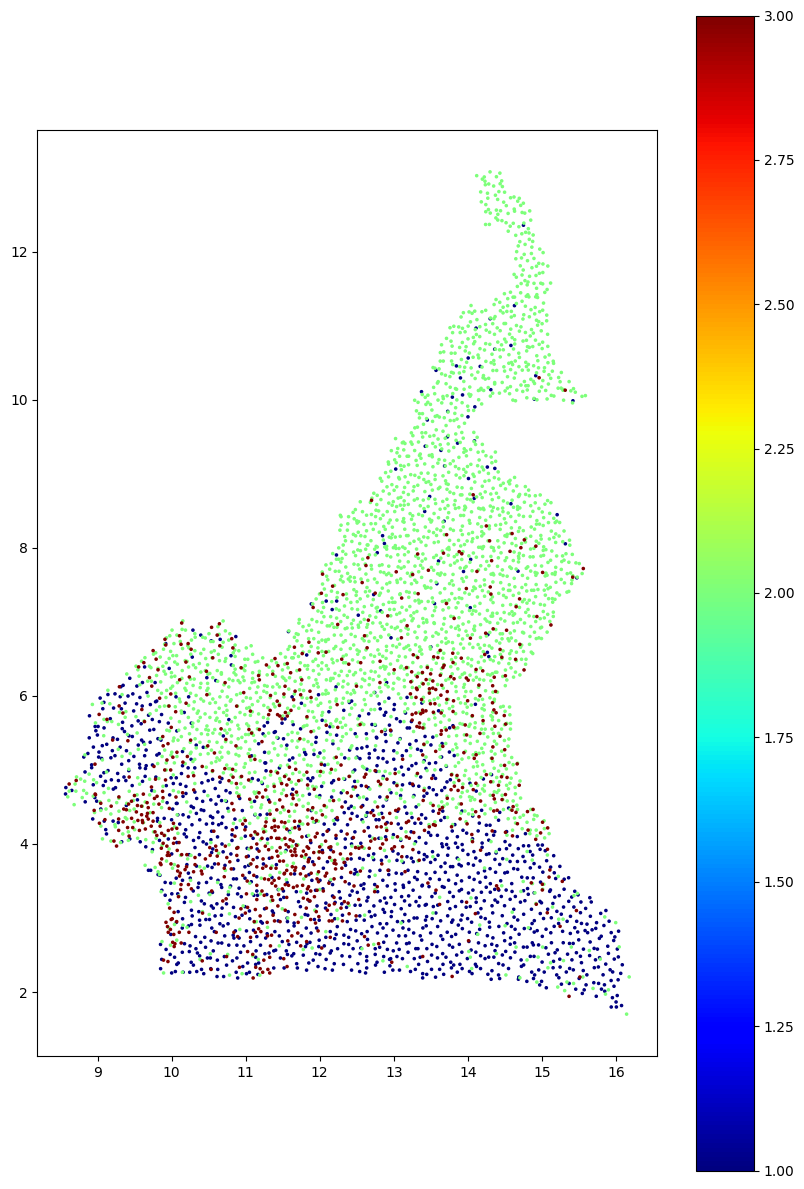

In [20]:
samples.plot('kmeans_chg_1520', markersize=2.5, cmap='jet', legend=True, figsize=(10,15))

### 3. align column names, get coordinates and randomize plotids for CEO


In [ ]:
joined_df['PLOTID'] = joined_df['point_id']

In [ ]:
joined_df['LON'] = joined_df.geometry.apply(lambda p: p.x)
joined_df['LAT'] = joined_df.geometry.apply(lambda p: p.y)

#### we want plotids in random order for CEO

In [ ]:
joined_df = joined_df.sample(frac=1).reset_index(drop=True)
joined_df = joined_df.rename(columns={"PLOTID": "OLD_PLOTID"})

start_id = int(joined_df["OLD_PLOTID"].max()) + 1
joined_df["PLOTID"] = range(start_id, start_id + len(joined_df))

In [ ]:
# if you want to export to QGIS
#samples.drop(['ts', 'dates','geometry_x','geometry_y'], axis=1).to_file('gabon_esbae_points_v1.gpkg', driver='GPKG')
#samples.to_file('cog_esbae_points_v1.gpkg', driver='GPKG')

In [ ]:
len(samples)

In [ ]:
samples.head()

In [ ]:
columns = samples.columns.tolist()
print(columns)

In [ ]:
samples_cols = ['PLOTID','LON', 'LAT', 'index', 'images', 'mon_images', 
                'bfast_change_date', 'bfast_magnitude', 'bfast_means', 'cusum_change_date', 'cusum_confidence', 'cusum_magnitude', 
                'red_mean', 'red_sd', 'red_min', 'red_max', 'nir_mean', 'nir_sd', 'nir_min', 'nir_max', 
                'swir1_mean', 'swir1_sd', 'swir1_min', 'swir1_max', 'swir2_mean', 'swir2_sd', 'swir2_min', 'swir2_max', 
                'ndfi_mean', 'ndfi_sd', 'ndfi_min', 'ndfi_max', 
                'brightness_mean', 'brightness_sd', 'brightness_min', 'brightness_max', 
                'greenness_mean', 'greenness_sd', 'greenness_min', 'greenness_max', 
                'wetness_mean', 'wetness_sd', 'wetness_min', 'wetness_max', 
                'bs_slope_mean', 'bs_slope_sd', 'bs_slope_max', 'bs_slope_min', 
                'ewma_jrc_date', 'ewma_jrc_change', 'ewma_jrc_magnitude', 
                'mosum_jrc_date', 'mosum_jrc_change', 'mosum_jrc_magnitude', 
                'cusum_jrc_date', 'cusum_jrc_change', 'cusum_jrc_magnitude', 
                'ccdc_change_date', 'ccdc_magnitude', 'aspect', 'dw_class_mode', 
                'dw_tree_prob__max', 'dw_tree_prob__min', 'dw_tree_prob__stdDev', 'dw_tree_prob_mean', 
                'elevation', 'esa_lc20', 'esa_lc21', 'esri_lc17', 'esri_lc18', 'esri_lc19', 'esri_lc20', 'esri_lc21', 
                'gfc_gain', 'gfc_loss', 'gfc_lossyear', 'gfc_tc00', 'lang_tree_height', 'potapov_tree_height', 'slope', 
                'tmf_2016', 'tmf_2017', 'tmf_2018', 'tmf_2019', 'tmf_2020', 'tmf_defyear', 'tmf_degyear', 'tmf_main', 'tmf_sub', 
                'geometry', 'point_id', 'Change_Bin', 'Def_Bin', 'Deg_Bin', 'CAFI_LC_2015', 'chg_prob_cafi1520', 'def_prob_cafi1520', 'deg_prob_cafi1520', 'simple_combined', 'kmeans_chg', 'kmeans_def', 'kmeans_deg', 'PLOTID', 'LON', 'LAT', 'kmeans_chg_1520', 'dist'
       ]

### 4. Extraction additional samples for CEO
##### this section is for adding new samples from strata 2 and 3 to intensify visual interprestation in change areas, while avoiding any duplicates with batch 1
##### this is only relevant if you have already completed the first CEO data collection and wish to add more CEO projects to reduce uncertainties

In [ ]:
#check columns of your first batch
batch1.columns

In [ ]:
#check for duplicates
#selection = samples[]
#set() in set()
doublon = set(samples["point_id"]).intersection(batch1["point_id"])
np.unique(doublon, return_counts=True)
len(doublon)

In [ ]:
np.unique(samples["kmeans_chg"], return_counts=True)

#### if there are batches already join them all

In [ ]:
merged_batch = pd.concat(batches)
#merged_batch = pd.concat([batch1, batch2,batch3, batch4, batch5])
len(merged_batch)

In [ ]:
merged_batch.columns

#### check for duplicates with previous batches and remove them

In [ ]:
selection = samples[samples["kmeans_chg"] > 1]
len(selection)

In [ ]:
sel_ids = set(selection["point_id"]) - set(merged_batch["point_id"])
len(sel_ids)

In [ ]:
doublon = set(selection["point_id"]).intersection(sel_ids)
len(doublon)

In [ ]:
doublon = set(batch1["point_id"]).intersection(sel_ids)
len(doublon)

In [ ]:
sel_final = selection[selection["point_id"].isin(sel_ids)]

In [ ]:
len(sel_final)

In [ ]:
sel_final.head()

### 5. export a new batch of samples for CEO

In [ ]:
sel_final.to_csv(samples_out_file,index=False)